# 基于处置效应的CGO因子

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/27009
# 标题：处置效应的CGO因子（行为金融学因子）

from jqlib import alpha191
from jqlib.alpha191 import *
from jqfactor import get_factor_values
from jqfactor import Factor
from jqfactor import analyze_factor
from jqdata import *
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore') 

In [2]:
market='000300.XSHG'
code_list = get_index_stocks(market)
# code_list=list(get_all_securities(types=['stock'], date=None).index)
start='2010-01-01'
end='2020-04-17'

# 因子分析

In [17]:
# 定义因子
class Capital_Gain_Overhang(Factor):
    name = 'CGO'
    max_window =100
    dependencies = ['money','volume','close','turnover_ratio']
    def calc(self, data):
        #获取成交价额
        money=np.array(data['money'][-100:])
        #获取成交量
        volume=np.array(data['volume'][-100:])
        #计算平均价
        avg=money/volume
        avg=np.nan_to_num(avg)#用0填充缺失值
        
        #获取最新收盘价
        close=list(np.array(data['close'][-100:]))
        close=close[-1]
        #获取换手率
        turnover_ratio=np.array(data['turnover_ratio'][-100:])
        turnover_ratio=np.nan_to_num(turnover_ratio)#用0填充缺失值
#         往前推N个交易日，每日成交均价乘以当日换手率并连乘后续日期的“不换手率”，
#         即为当天成本“延续”到现在的比例，把所有"N个交易日延续到现在的成本"根据比例加权平均即为成本价。
        func=lambda i: turnover_ratio[i] / 100 * np.prod(1 - turnover_ratio[i + 1:] / 100)
        weighted_turnover_list = list(map(func, range(len(turnover_ratio))))
        weighted_turnover_list = np.array(weighted_turnover_list) / sum(weighted_turnover_list)
        cost_price=sum(avg * weighted_turnover_list)
        cgo=close/cost_price-1
        return cgo


In [8]:
# 计算因子值
# factors = calc_factors(code_list, [Capital_Gain_Overhang()], start_date=start, end_date=end,  use_real_price=True, skip_paused=False)
# # 查看因子值
# factors['CGO']

In [19]:
# #获取因子值
# factor_data=get_factor_values(securities=code_list, factors=[Capital_Gain_Overhang],start_date=start, end_date=end)['CGO']
# factor_data()

In [18]:
far = analyze_factor(Capital_Gain_Overhang(), start_date=start, end_date=end
                     ,weight_method='mktcap',universe='000300.XSHG', 
                     quantiles=10, periods=(1,5,22)
                    )

# 收益分析

In [20]:
far.plot_returns_table(demeaned=False, group_adjust=False)

收益分析


,period_1,period_5,period_22
Ann. alpha,0.029,0.023,0.022
beta,-0.044,-0.066,-0.076
Mean Period Wise Return Top Quantile (bps),3.767,3.723,3.972
Mean Period Wise Return Bottom Quantile (bps),2.081,2.069,2.343
Mean Period Wise Spread (bps),1.685,1.414,1.329


<Figure size 432x288 with 0 Axes>

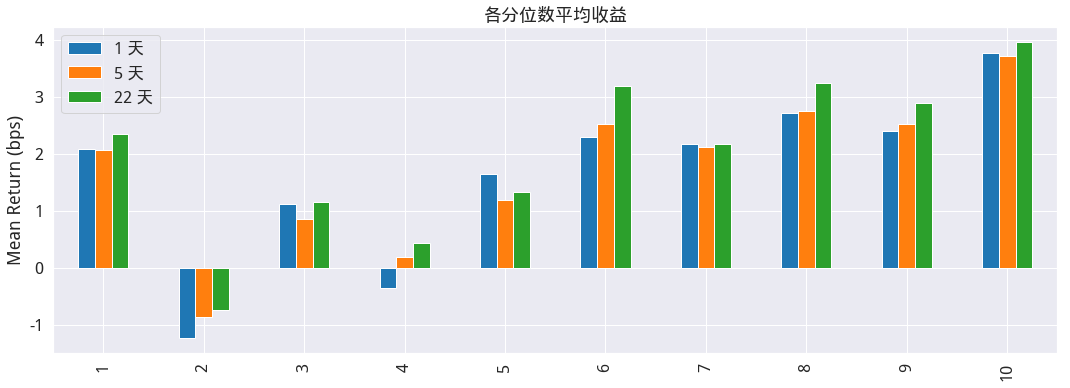

In [21]:
# 画各分位数平均收益图
far.plot_quantile_returns_bar(by_group=False, demeaned=0, group_adjust=False)

<Figure size 432x288 with 0 Axes>

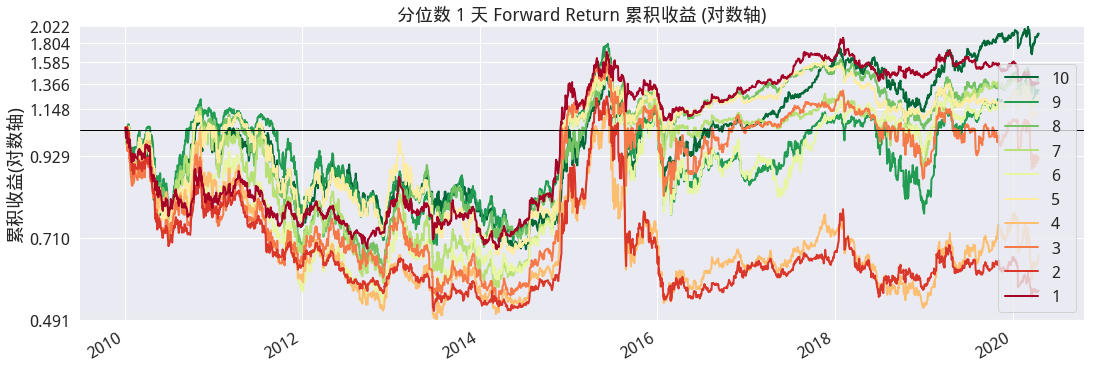

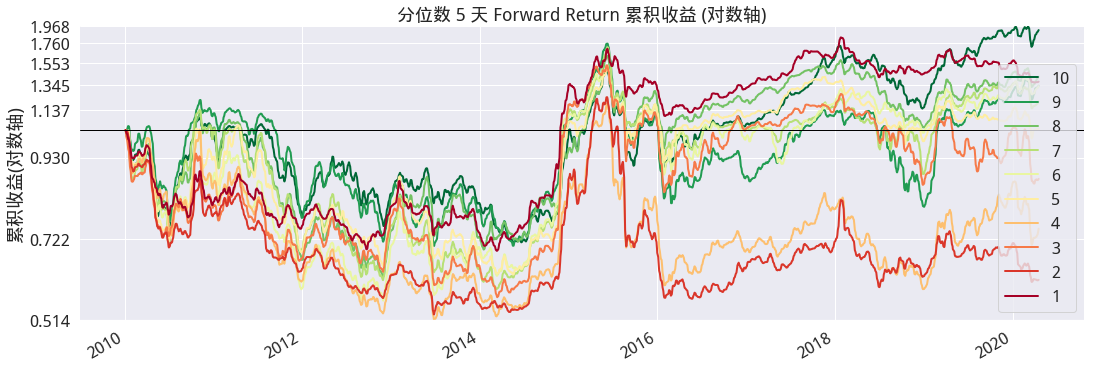

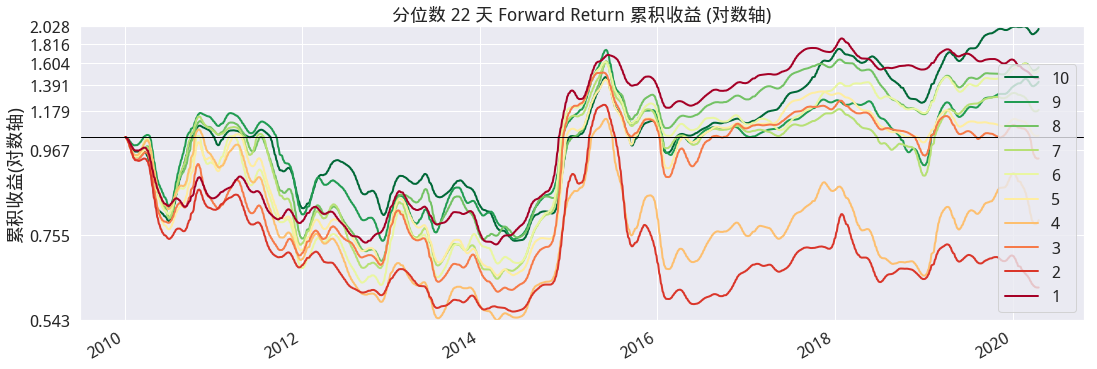

In [23]:
# 各分位数累计收益率图
periods=(1,5,22)
far.plot_cumulative_returns_by_quantile(period=periods, demeaned=0, group_adjust=False)

<Figure size 432x288 with 0 Axes>

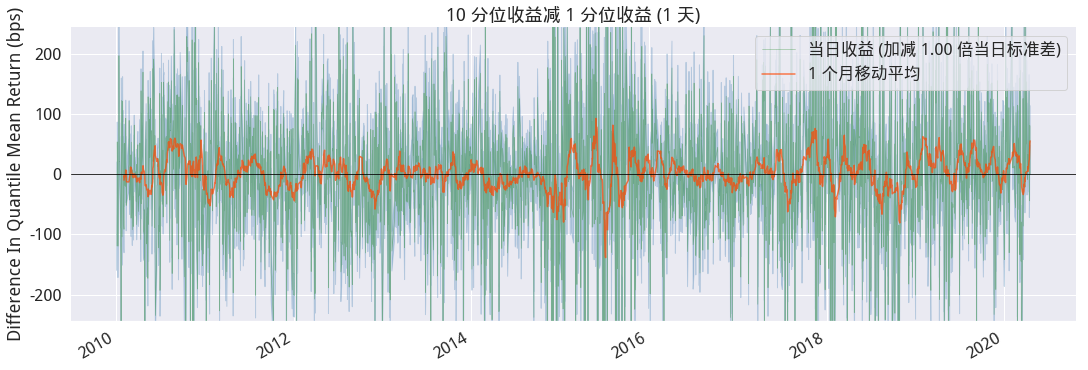

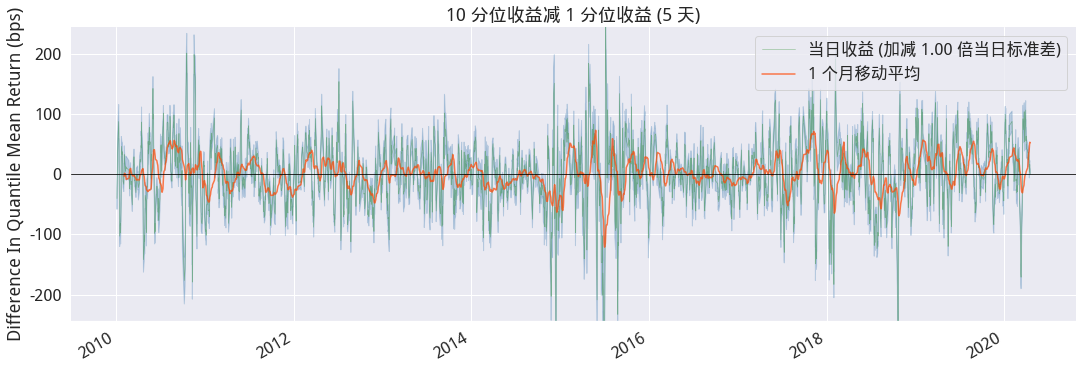

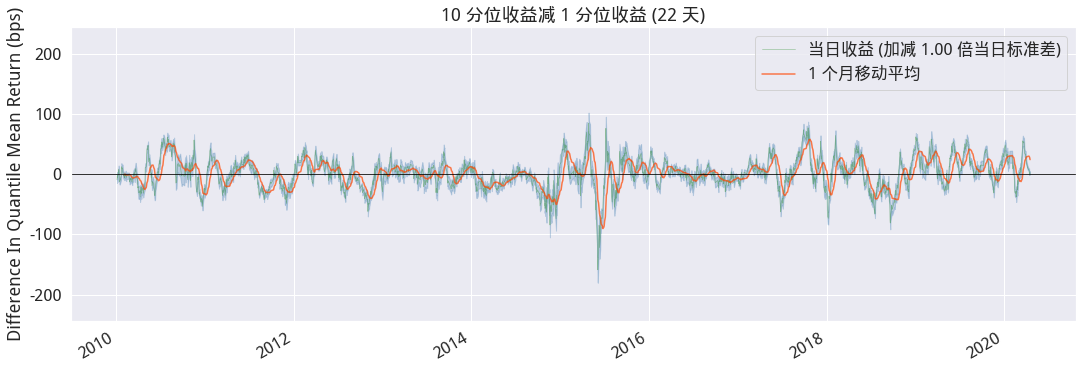

In [24]:
# 画最高分位减最低分位收益图
far.plot_mean_quantile_returns_spread_time_series(demeaned=False, group_adjust=False, bandwidth=1)

<Figure size 432x288 with 0 Axes>

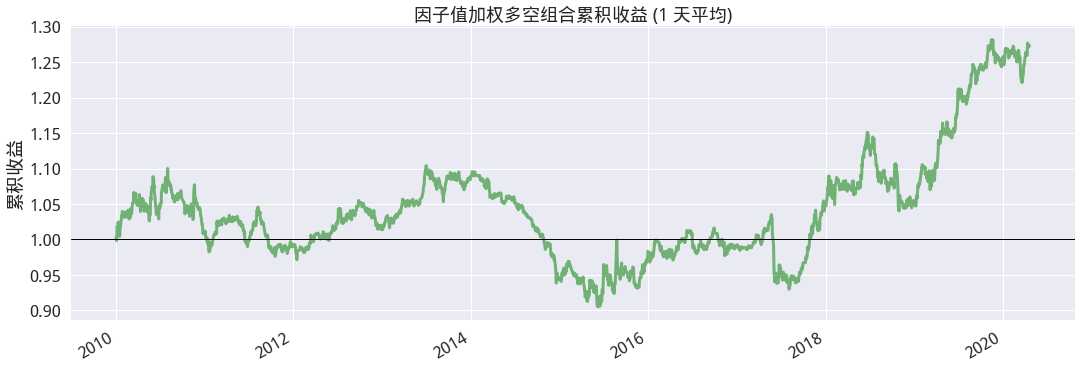

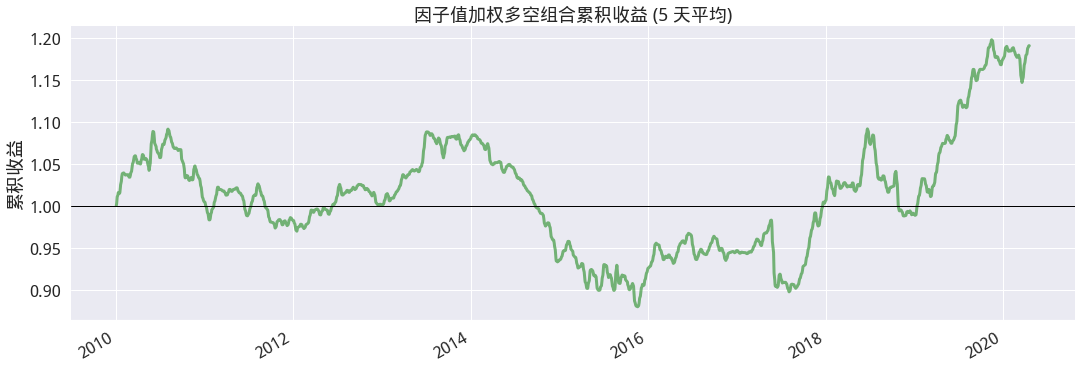

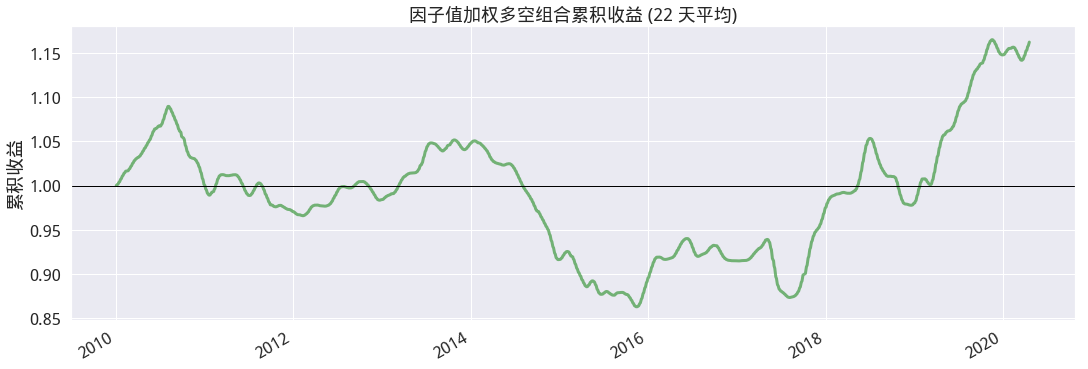

In [25]:
# 画按因子值加权多空组合累积收益图
for i in periods:
    far.plot_cumulative_returns(period=i, demeaned=False, group_adjust=False)

# 信息分析

In [26]:
# 打印信息比率（IC）相关表
far.plot_information_table(group_adjust=False, method='rank')

IC 分析


,period_1,period_5,period_22
IC Mean,0.003,0.013,0.020
IC Std.,0.142,0.155,0.164
IR,0.022,0.086,0.120
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


<Figure size 432x288 with 0 Axes>

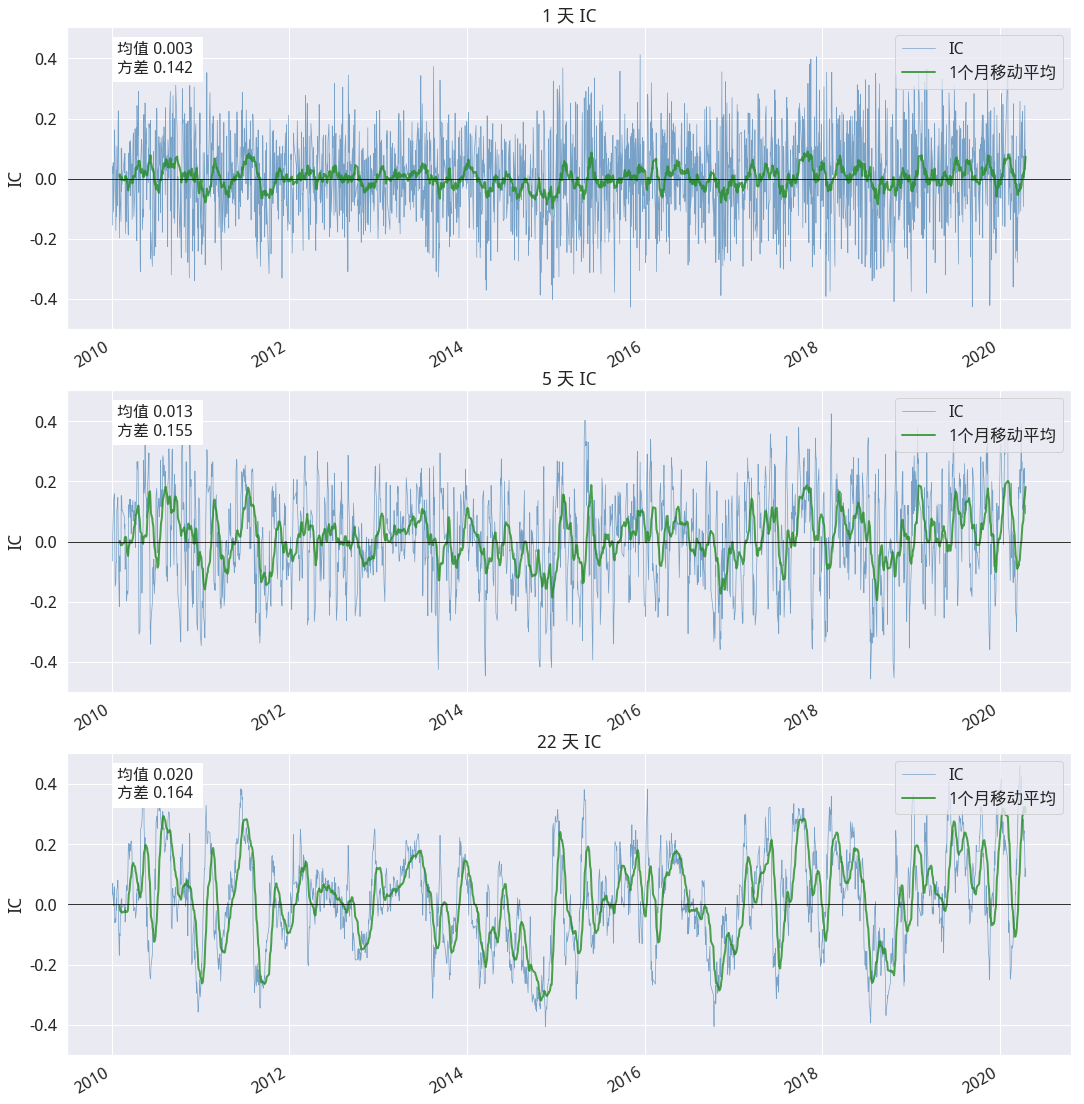

In [27]:
# 画信息比率(IC)时间序列图
far.plot_ic_ts(group_adjust=False, method='rank')

<Figure size 432x288 with 0 Axes>

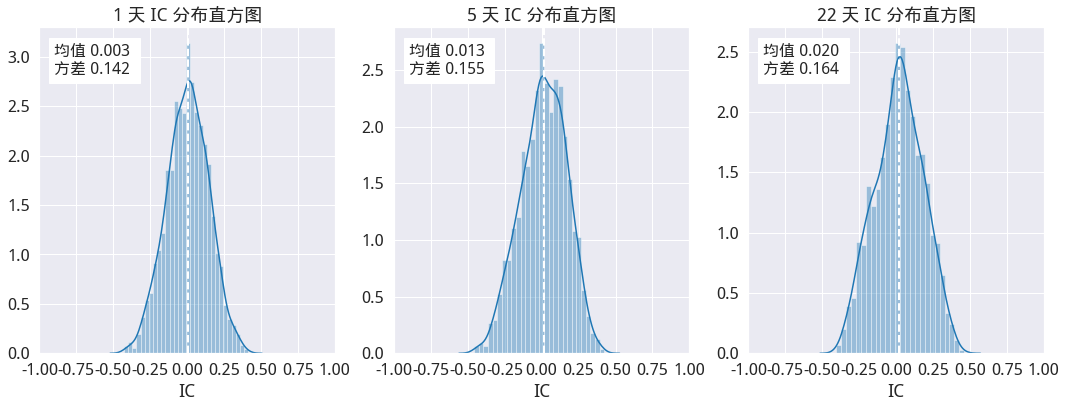

In [28]:
# 画信息比率分布直方图
far.plot_ic_hist(group_adjust=False, method='rank')

<Figure size 432x288 with 0 Axes>

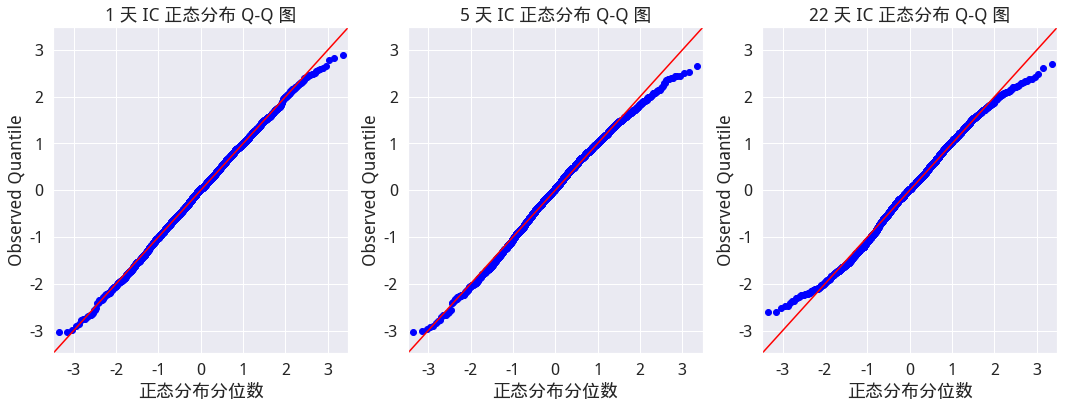

In [29]:
# 画信息比率 qq 图
far.plot_ic_qq(group_adjust=False, method='rank', theoretical_dist='norm')

<Figure size 432x288 with 0 Axes>

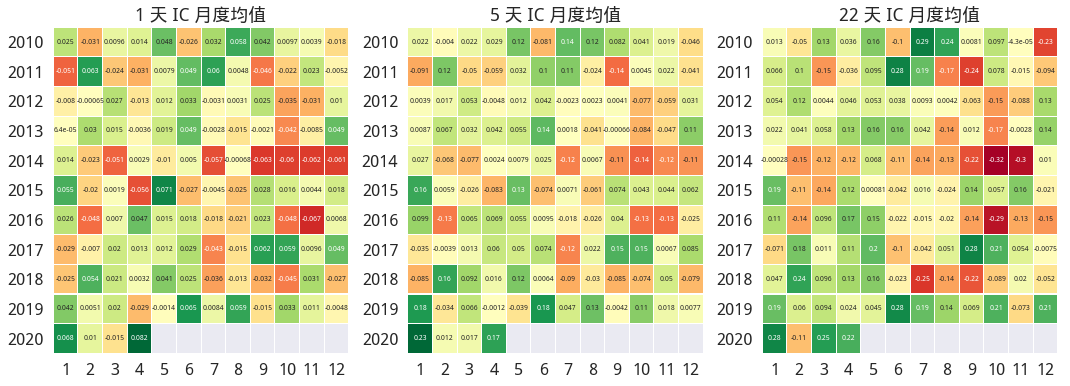

In [30]:
# 画月度信息比率(IC)图
far.plot_monthly_ic_heatmap(group_adjust=False)

# 换手率分析

In [31]:
# 打印换手率表
far.plot_turnover_table()

换手率分析


,period_1,period_22,period_5
Quantile 1 Mean Turnover,0.011,0.060,0.026
Quantile 2 Mean Turnover,0.022,0.113,0.051
Quantile 3 Mean Turnover,0.027,0.138,0.062
Quantile 4 Mean Turnover,0.034,0.168,0.077
Quantile 5 Mean Turnover,0.040,0.188,0.088
Quantile 6 Mean Turnover,0.043,0.203,0.095
Quantile 7 Mean Turnover,0.045,0.209,0.102
Quantile 8 Mean Turnover,0.047,0.208,0.103
Quantile 9 Mean Turnover,0.039,0.173,0.084
Quantile 10 Mean Turnover,0.016,0.069,0.034


,period_1,period_5,period_22
Mean Factor Rank Autocorrelation,1.0,0.999,0.997


<Figure size 432x288 with 0 Axes>

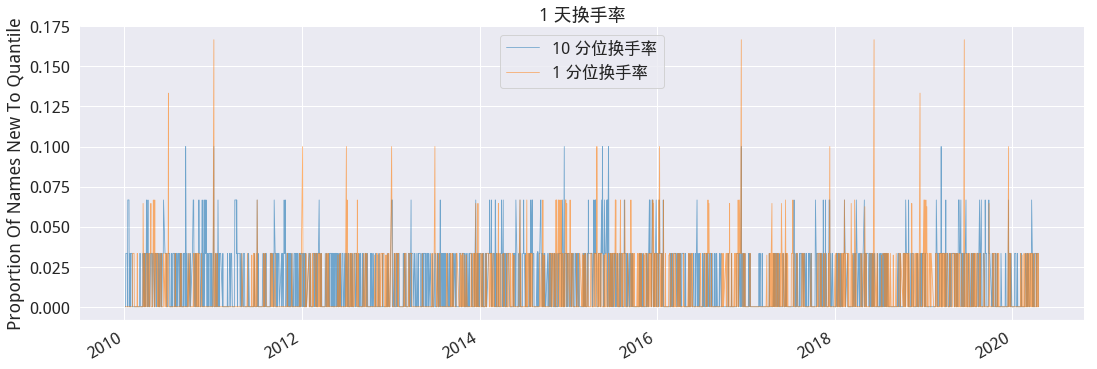

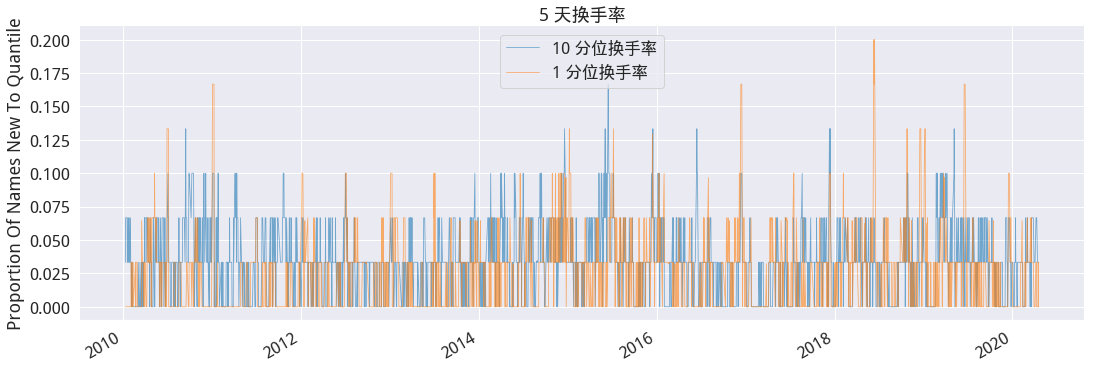

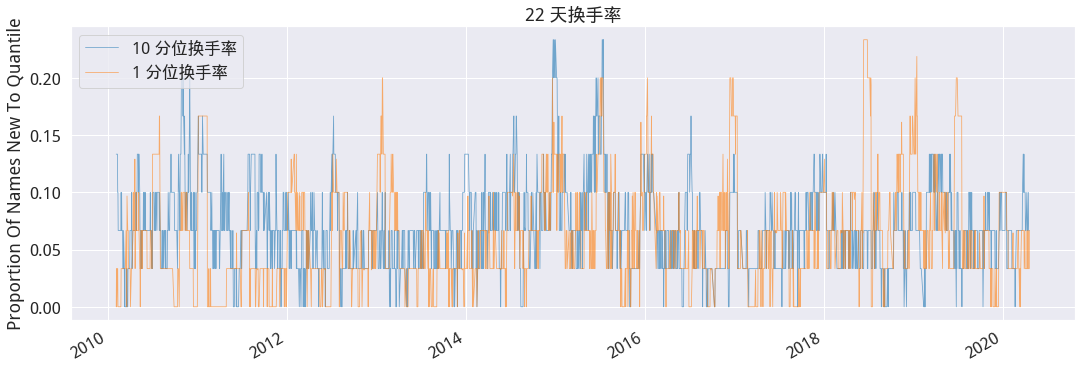

In [32]:
# 画最高最低分位换手率图
far.plot_top_bottom_quantile_turnover(periods=periods)

<Figure size 432x288 with 0 Axes>

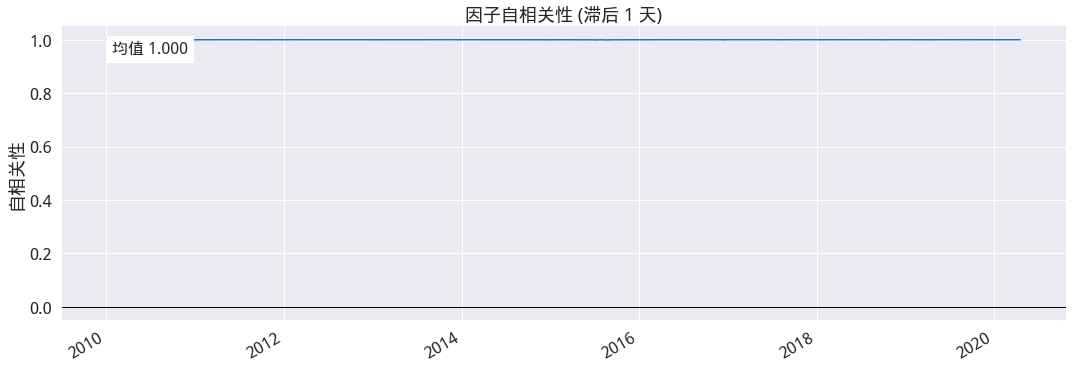

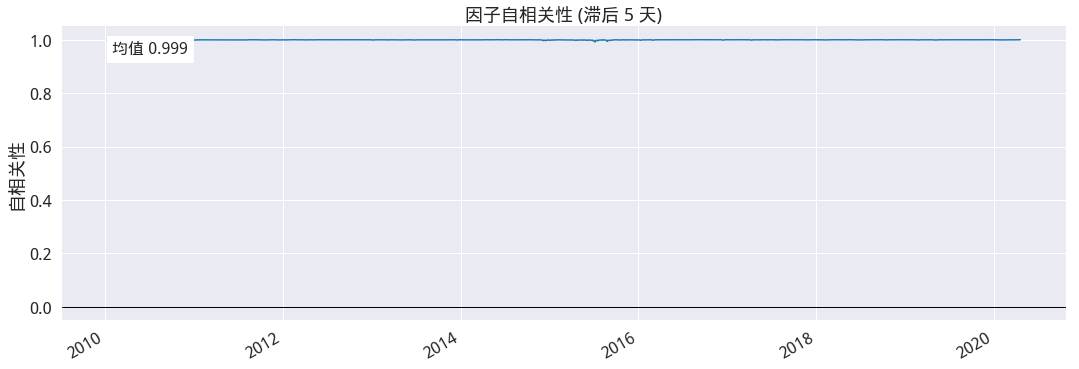

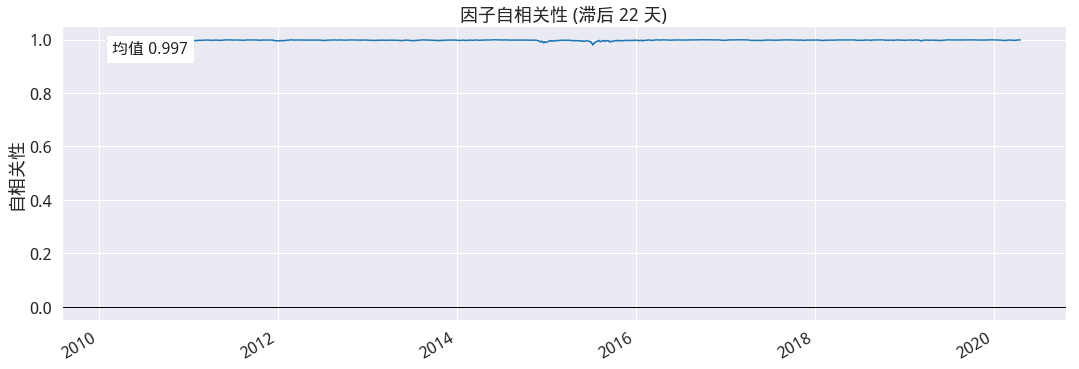

In [33]:
# 画因子自相关图
far.plot_factor_auto_correlation(rank=True)

In [3]:
# 1. 前100个交易日的成交均价
def avg_dict(code_list):
    avg_dict = {}
    latest_close = {}
    for code in code_list:   
        df = attribute_history(code, 100, '1d', ['avg', 'close','paused'], skip_paused=False, df=False) # 因需要记录日期，所以不能用dict形式
        close = df['close']
        avg = df['avg']
        paused = df['paused']    
        # 排除停牌过多情况    
        if sum(paused) > 50:
            continue
        # 排除近10日跌停情况
        if sum((close[-10:] / close[-11:-1] - 1) < -0.095) > 0:
            continue
        latest_close[code] = close[-1] # 记录最新收盘价
        avg_dict[code] = avg
    return pd.DataFrame(avg_dict),dict_close

In [4]:
df_avg,dict_close=avg_dict(code_list)

In [5]:
df_avg

,000001.XSHE,000002.XSHE,000063.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000413.XSHE,000415.XSHE,000423.XSHE,000425.XSHE,000538.XSHE,000568.XSHE,000596.XSHE,000625.XSHE,000627.XSHE,000629.XSHE,000630.XSHE,000651.XSHE,000656.XSHE,000661.XSHE,000671.XSHE,000703.XSHE,000709.XSHE,000723.XSHE,000725.XSHE,000728.XSHE,000768.XSHE,000776.XSHE,000783.XSHE,000786.XSHE,000858.XSHE,000876.XSHE,000895.XSHE,000898.XSHE,000938.XSHE,000961.XSHE,000963.XSHE,...,601669.XSHG,601688.XSHG,601698.XSHG,601727.XSHG,601766.XSHG,601788.XSHG,601800.XSHG,601808.XSHG,601818.XSHG,601828.XSHG,601838.XSHG,601857.XSHG,601877.XSHG,601878.XSHG,601881.XSHG,601888.XSHG,601898.XSHG,601899.XSHG,601901.XSHG,601919.XSHG,601933.XSHG,601939.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601992.XSHG,601997.XSHG,601998.XSHG,603019.XSHG,603156.XSHG,603160.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603501.XSHG,603799.XSHG,603833.XSHG,603899.XSHG,603986.XSHG,603993.XSHG
0,15.93,26.74,31.58,6.90,3.47,6.09,4.73,57.47,12.85,4.80,3.47,35.38,4.35,93.78,87.26,115.03,8.66,6.60,2.72,2.13,58.94,6.74,488.11,6.76,12.72,2.42,7.97,3.68,8.22,15.53,13.13,6.34,21.90,134.39,22.43,32.22,2.97,29.31,8.35,25.45,...,4.09,17.15,11.02,4.67,6.92,11.19,8.45,16.05,4.25,10.78,8.57,5.51,23.53,8.51,10.48,86.42,4.69,3.44,6.59,4.83,7.63,7.12,4.78,3.63,5.26,3.19,9.21,6.04,34.25,29.06,215.75,99.24,28.21,114.72,125.07,27.88,103.38,49.60,173.48,3.45
1,15.77,26.68,31.08,6.85,3.49,6.00,4.71,56.14,12.66,4.80,3.44,34.73,4.32,92.62,87.59,113.47,8.68,6.52,2.72,2.11,57.56,6.59,478.99,6.61,12.72,2.43,8.04,3.67,8.21,15.64,13.05,6.30,21.68,133.32,22.00,31.51,3.05,28.63,8.10,24.99,...,4.03,17.00,10.74,4.64,6.86,11.14,8.37,15.93,4.20,10.68,8.48,5.58,23.15,8.43,10.29,85.75,4.66,3.50,6.55,4.74,7.54,7.10,4.76,3.62,5.31,3.18,9.08,5.98,33.80,29.22,210.84,95.81,28.24,112.72,124.41,27.78,100.98,49.58,169.86,3.42
2,15.72,26.94,30.94,6.81,3.49,5.96,4.73,56.26,12.84,4.80,3.46,34.08,4.32,90.69,85.18,113.36,8.59,6.51,2.73,2.13,57.09,6.53,458.76,6.57,12.90,2.46,8.30,3.67,8.23,15.64,13.08,6.30,21.71,130.77,21.75,31.26,3.08,27.42,8.00,24.86,...,4.08,17.02,10.56,4.66,6.92,11.12,8.69,16.68,4.19,10.70,8.46,5.61,23.23,8.47,10.28,85.30,4.68,3.59,6.56,4.72,7.59,7.13,4.79,3.62,5.27,3.20,9.05,6.01,33.62,29.02,208.24,92.28,28.25,110.60,120.98,28.21,100.58,48.19,166.26,3.45
3,15.75,28.19,30.02,6.94,3.56,6.03,4.71,55.95,13.28,4.80,3.51,33.93,4.40,89.11,83.21,111.55,8.62,6.52,2.79,2.17,57.28,6.65,449.52,7.04,12.91,2.55,8.31,3.68,8.25,15.55,13.12,6.28,22.66,127.67,21.22,31.18,3.22,26.48,8.33,24.86,...,4.18,17.01,10.24,4.71,7.03,11.11,9.08,16.68,4.25,10.72,8.53,5.68,23.26,8.45,10.27,83.06,4.83,3.72,6.57,4.81,7.60,7.20,4.87,3.64,5.27,3.28,9.13,6.05,32.60,29.16,188.16,89.26,27.95,108.60,112.65,28.08,99.12,46.75,159.50,3.51
4,15.60,28.35,30.43,7.04,3.72,6.07,4.76,56.73,13.32,4.80,3.52,34.16,4.51,90.79,85.17,112.62,8.73,6.60,2.80,2.16,58.36,6.65,462.88,6.97,13.39,2.56,8.07,3.86,8.35,15.91,13.18,6.29,22.83,129.98,21.14,31.59,3.15,27.14,8.46,25.27,...,4.18,17.08,10.22,4.73,7.04,11.19,9.08,16.72,4.24,10.76,8.59,5.67,23.82,8.48,10.26,85.18,4.86,3.72,6.64,4.83,7.64,7.23,4.92,3.66,5.37,3.30,9.19,6.11,32.66,29.75,189.40,90.41,27.74,110.49,117.71,28.35,101.18,47.05,161.40,3.50
5,15.47,28.12,30.38,7.01,3.73,6.09,4.75,55.07,13.41,4.80,3.48,34.28,4.58,89.84,86.04,111.78,8.50,6.62,2.80,2.15,57.43,6.62,458.43,7.01,13.54,2.56,8.12,3.87,8.32,15.85,13.10,6.27,22.98,131.25,20.92,31.10,3.15,27.26,8.55,25.27,...,4.13,16.97,10.22,4.71,7.03,11.12,8.99,17.17,4.21,10.73,8.63,5.67,23.51,8.35,10.21,84.54,4.87,3.69,6.64,4.76,7.49,7.20,4.90,3.66,5.35,3.30,9.21,6.05,33.27,29.65,193.57,89.79,27.67,109.76,125.47,30.28,101.83,46.08,165.32,3.60
6,15.48,27.79,30.57,6.93,3.74,6.01,4.74,55.13,13.15,4.80,3.43,33.94,4.58,89.99,84.92,112.55,8.35,6.65,2.78,2.14,58.32,6.59,459.95,6.96,13.55,2.52,8.33,3.88,8.29,15.73,13.10,6.22,22.84,131.25,21.00,31.00,3.15,27.37,8.28,24.96,...,4.11,16.96,10.11,4.69,7.00,11.15,9.17,16.86,4.18,10.71,8.56,5.63,23.78,8.33,10.27,83.34,4

In [19]:
# 2. 获取前100个交易日的换手率
t1='2020-3-1'
date_list = get_trade_days(end_date=t1, count=100)
def turnover_ratio(code_list,date_list):
    turnover_ratio_dict = {}
    for date in all_dates:
        q = query(valuation.code,valuation.turnover_ratio,valuation.day).filter(valuation.code.in_(code_list))
        df = get_fundamentals(q, date=date)
        code = df['code'].values
        turnover_ratio = df['turnover_ratio'].values    
        # 没有数据的股票(新股),用0填充换手率缺失的数据
        nan_code = list(set(avg_dict.keys()) - set(code))
        for i in range(len(nan_code)):
            if nan_code[i] in turnover_ratio_dict:
                turnover_ratio_dict[nan_code[i]].append(0)
            else:
                turnover_ratio_dict[nan_code[i]] = [0]
        # 有数据的股票
        for i in range(len(code)):
    #         数据缺失
            if np.isnan(turnover_ratio[i]):
                turnover_ratio[i] = 0
            if code[i] in turnover_ratio_dict:
                turnover_ratio_dict[code[i]].append(turnover_ratio[i])
            else:
                turnover_ratio_dict[code[i]] = [turnover_ratio[i]]
    return pd.DataFrame(turnover_ratio_dict)


In [95]:
# 2. 获取前100个交易日的换手率
t1='2020-3-1'
date_list = get_trade_days(end_date=t1, count=100)
def turnover_ratio(code_list,date_list):
    for k,date in enumerate(date_list):
        q = query(valuation.code,valuation.turnover_ratio).filter(valuation.code.in_(code_list))
        df = get_fundamentals(q, date=date)
        if k==0:
            df1=df
        else:
            df1=df1.merge(df,on='code',how='outer')#用‘outer，方式合并，’nan填充缺失
    df2=df1.set_index(['code'])#以代码为索引
    df3=df2.T#进行转置
    df3.reset_index(drop=True, inplace=True)#重新设置索引
    df3.fillna(0,inplace=True)#用0填充所有缺失值
    return df3
